# Análisis de la clasificación de los hogares pobres en Costa Rica, según su grado de severidad de la pobreza

Proyecto Aprendizaje no Supervisado

Repositorio en Github: https://github.com/mauroverssi/Proyecto-final-aprendizaje-no-supervisado

Integrantes:
- Mauricio Roverssi
- Juan Sebastián Paniagua
- Juan Pablo Novoa

## 1. Importar librerías

In [1]:
# Importar librerias
# Paquetes básicos

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paquetes para modelos
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors         # Para determinar eps en DBSCAN
from kneed import KneeLocator                          # Para encontrar codo de la gráfica
from sklearn.cluster import DBSCAN                     # DBSCAN
from pca import pca
import gower


from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import linkage, fcluster

## 2. Importar datos y selección de variables

In [2]:
# Cargar resultado encuesta (filas: 31963, columnas: 595)
df_completo=pd.read_spss('data/ENAHO 2021.sav')

# Seleccionar campos de interés para el modelo
campos_seleccionados = ['ZONA','V7A','V7B','V7C', 'V10', 'V11', 'V12', 'V13A', 'V13B', 'V17A','V18F','V18G', 'V19',
                        'CalViv','HacDor','TamViv',
                        'NivInst', 'IPM_E1', 'IPM_E2', 'IPM_E3', 'IPM_E4',
                        'IPM_VUI1', 'IPM_VUI2', 'IPM_VUI3','IPM_VUI4',
                        'IPM_S1', 'IPM_S2', 'IPM_S3', 'IPM_S4',
                        'IPM_T1', 'IPM_T2.1', 'IPM_T2.2', 'IPM_T3',
                        'IPM_PS1', 'IPM_PS2', 'IPM_PS3', 'IPM_PS4',
                        'D_IPCN', 'ithn', 'ttmh', 'tnmh',
                        'A4', 'A5','A8A', 'A9A', 'A10A', 'A11', 'A13',
                        'cba',
                        'IPM_Pobreza'
                       ]

df =df_completo[campos_seleccionados]
df = df.dropna()        # Retirar filas sin valores
df_IPobreza = df['IPM_Pobreza']    # Dataframe con resultado de probreza multidimensional
df.drop(['IPM_Pobreza'], axis=1, inplace=True)

# Renombrar columnas
df = df.rename(columns={'ZONA': 'Zona',
                          'V7A': 'Est Paredes exterior',
                          'V7B': 'Est techo',
                          'V7C': 'Est piso',
                          'CalViv': 'Calificación vivienda',
                          'HacDor': 'Hacinamiento',
                          'V10': 'Mts2 vivienda',
                          'V11': 'Abastecimiento agua',
                          'V12': 'Fuente agua',
                          'V13A': 'Servicio sanitario',
                          'V13B': 'Exclusividad  Serv sanitario',
                          'V17A': 'Sistema eliminación basura',
                          'V18F': 'Tiene computador portátil',
                          'V18G': 'Tiene computador escritorio',
                          'TamViv': 'Personas en vivienda',
                          'A4': 'Sexo',
                          'V19': 'Tiene internet',
                          'A5': 'Edad',
                          'NivInst': 'Nivel de instrucción',
                          'IPM_E1': 'E1 No educación formal',
                          'IPM_E2': 'E2 Rezago educativo',
                          'IPM_E3': 'E3 Sin bachillerato',
                          'IPM_E4': 'E4 Bajo desarrollo',
                          'IPM_VUI1': 'VUI1 Mal Est techo piso',
                          'IPM_VUI2': 'VUI2 Mal Est paredes ext',
                          'IPM_VUI3': 'VUI3 Hacinamiento',
                          'IPM_VUI4': 'VUI3 Sin uso internet',
                          'IPM_S1': 'S1 Sin seguro salud',
                          'IPM_S2': 'S2 Sin servicio agua',
                          'IPM_S3': 'S3 Sin eliminación excretas',
                          'IPM_S4': 'S4 Sin eliminacion basura',
                          'IPM_T1': 'T1 Desempleo larga duracion',
                          'IPM_T2.1': 'T2 Incumplim Salario Mínimo',
                          'IPM_T2.2': 'T2 Incumplim otros derechos',
                          'IPM_T3': 'T3 Independiente informal',
                          'IPM_PS1': 'PS1 Infancia sin cuido',
                          'IPM_PS2': 'PS2 Adulto mayor sin pension',
                          'IPM_PS3': 'PS3 Con Discapacidad sin transf.',
                          'IPM_PS4': 'PS4 No labora obligación familiar',
                          'ttmh': 'Total Transf Monetaria Hogar',
                          'D_IPCN': 'Decil ingreso per cápita hogar',
                          'ithn': 'Ingreso neto hogar',
                          'tnmh': 'Transf no monetaria hogar',
                          'A8A': 'Primera mencion discapacidad',
                          'A9A': 'Recibió ayuda IMAS',
                          'A11': 'Condicion aseguramiento',
                          'A13': 'Asistencia a educación formal',
                          'A10A': 'Primera mencion Cen-Cinai',
                          'cba': 'Canasta Básica Alimentaria'
                       })

# Cambiar formato datos Edad
df['Edad'] = df['Edad'].astype(str)
df.loc[df["Edad"] == '97 años o más', "Edad"] = 97
df.loc[df["Edad"] == 'Menos de 1 año', "Edad"] = 0
df['Edad'] = df['Edad'].astype(float)

# Identificar variables categóricas y numéricas
vars_categoricas = df.select_dtypes(include=['category']).columns
vars_numericas = df.select_dtypes(include=['float64']).columns

df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.head()

,Zona,Est Paredes exterior,Est techo,Est piso,Mts2 vivienda,Abastecimiento agua,Fuente agua,Servicio sanitario,Exclusividad Serv sanitario,Sistema eliminación basura,...,Total Transf Monetaria Hogar,Transf no monetaria hogar,Sexo,Edad,Primera mencion discapacidad,Recibió ayuda IMAS,Primera mencion Cen-Cinai,Condicion aseguramiento,Asistencia a educación formal,Canasta Básica Alimentaria
0,Urbana,Bueno,Regular,Regular,De 61m² a 100m²,Tubería dentro de la vivienda,Acueducto del A y A,Conectado a alcantarilla o cloaca,Sólo para esta vivienda,Camión recolector,...,140833.333333,0.0,Mujer,49.0,No tiene ninguna,No ha recibido,No ha recibido,Voluntario,No asiste,51307.0
1,Urbana,Bueno,Regular,Regular,De 61m² a 100m²,Tubería dentro de la vivienda,Acueducto del A y A,Conectado a alcantarilla o cloaca,Sólo para esta vivienda,Camión recolector,...,140833.333333,0.0,Hombre,59.0,Caminar o subir gradas,No ha recibido,No ha recibido,Pensionado del régimen de IVM de la CCSS,No asiste,51307.0
2,Urbana,Bueno,Regular,Regular,De 61m² a 100m²,Tubería dentro de la vivienda,Acueducto del A y A,Conectado a alcantarilla o cloaca,Sólo para esta vivienda,Camión recolector,...,140833.333333,0.0,Mujer,27.0,No tiene ninguna,No ha recibido,No ha recibido,Asalariado,No asiste,51307.0
3,Urbana,Bueno,Regular,Regular,De 61m² a 100m²,Tubería dentro de la vivienda,Acueducto del A y A,Conectado a alcantarilla o cloaca,Sólo para esta vivienda,Camión recolector,...,140833.333333,0.0,Mujer,24.0,No tiene ninguna,No ha recibido,No ha recibido,Asalariado,Universitaria,51307.0
4,Urbana,Malo,Bueno,Malo,De 30m² a 40m²,Tubería dentro de la vivienda,Acueducto del A y A,Conectado a alcantarilla o cloaca,Sólo para esta vivienda,Camión recolector,...,175666.666667,0.0,Mujer,37.0,No tiene ninguna,No ha recibido,No ha recibido,Asalariado,No asiste,51307.0


## 3. Estadísticas descriptivas de variables seleccionadas

In [3]:
total_hogares = df.shape[0]
print('El dataset tiene ',len(vars_categoricas) , 'variables categóricas')
print('El dataset tiene ',len(vars_numericas) , 'variables numéricas')
print('El dataset tiene ', total_hogares, 'registros (filas)')

El dataset tiene  43 variables categóricas
El dataset tiene  6 variables numéricas
El dataset tiene  31827 registros (filas)


### Estadísticas descriptivas de variables categóricas asociadas a la condición de la vivienda

<AxesSubplot:xlabel='Zona', ylabel='Count'>

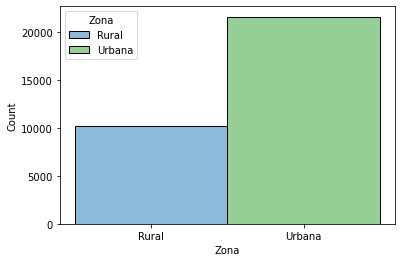

In [7]:
# Distribución Rural / Urbana
palette = ['tab:blue', 'tab:green']
palette = {'Rural': 'tab:blue', 'Urbana': 'tab:green'}
sns.histplot(data=df[['Zona']], x='Zona',  hue='Zona',  palette=palette)

<AxesSubplot:xlabel='Est piso', ylabel='Count'>

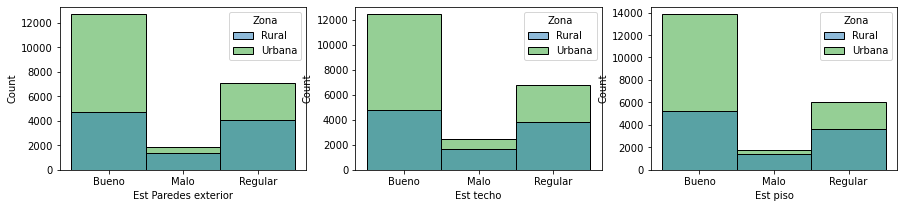

In [8]:
# Estado de paredes exterior, techos y pisos
fig, axes = plt.subplots(1, 3, figsize=(15,3))
sns.histplot(data=df[['Est Paredes exterior','Zona']], x='Est Paredes exterior',  hue='Zona', ax=axes[0],  palette=palette)
sns.histplot(data=df[['Est techo','Zona']], x='Est techo',  hue='Zona', ax=axes[1],  palette=palette)
sns.histplot(data=df[['Est piso','Zona']], x='Est piso',  hue='Zona', ax=axes[2],  palette=palette)

<AxesSubplot:xlabel='Sistema eliminación basura', ylabel='Count'>

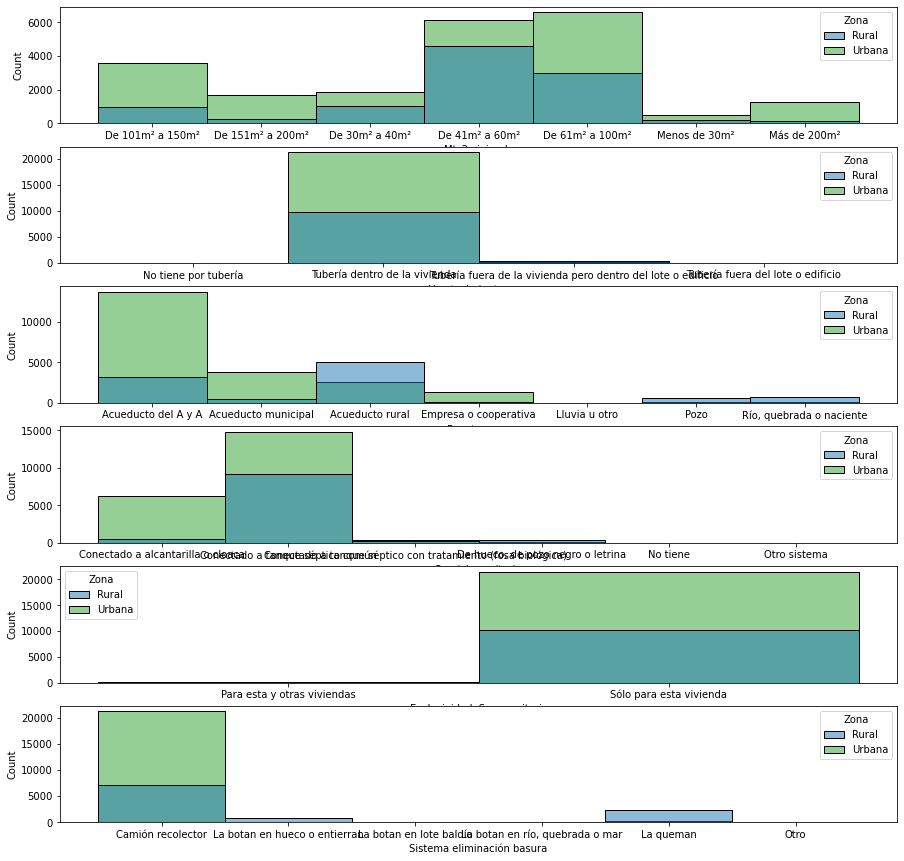

In [9]:
# Condiciones de servicios de las viviendas
fig, axes = plt.subplots(6, 1, figsize=(15,15))
sns.histplot(data=df[['Mts2 vivienda','Zona']], x='Mts2 vivienda',  hue='Zona', ax=axes[0],  palette=palette)
sns.histplot(data=df[['Abastecimiento agua','Zona']], x='Abastecimiento agua',  hue='Zona', ax=axes[1],  palette=palette)
sns.histplot(data=df[['Fuente agua','Zona']], x='Fuente agua',  hue='Zona', ax=axes[2],  palette=palette)
sns.histplot(data=df[['Servicio sanitario','Zona']], x='Servicio sanitario',  hue='Zona', ax=axes[3],  palette=palette)
sns.histplot(data=df[['Exclusividad  Serv sanitario','Zona']], x='Exclusividad  Serv sanitario',  hue='Zona', ax=axes[4],  palette=palette)
sns.histplot(data=df[['Sistema eliminación basura','Zona']], x='Sistema eliminación basura',  hue='Zona', ax=axes[5],  palette=palette)

<AxesSubplot:xlabel='Tiene internet', ylabel='Count'>

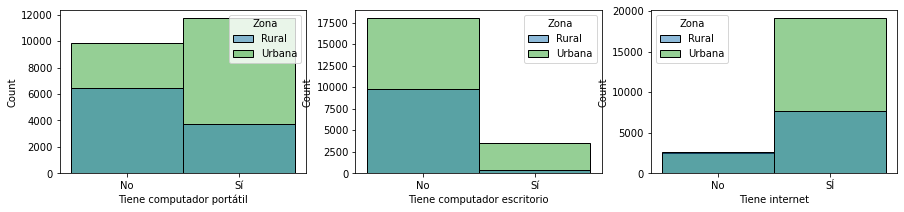

In [10]:
# Acceso a tecnología
fig, axes = plt.subplots(1, 3, figsize=(15,3))
sns.histplot(data=df[['Tiene computador portátil','Zona']], x='Tiene computador portátil',  hue='Zona', ax=axes[0],  palette=palette)
sns.histplot(data=df[['Tiene computador escritorio','Zona']], x='Tiene computador escritorio',  hue='Zona', ax=axes[1],  palette=palette)
sns.histplot(data=df[['Tiene internet','Zona']], x='Tiene internet',  hue='Zona', ax=axes[2],  palette=palette)

<AxesSubplot:xlabel='Calificación vivienda', ylabel='Count'>

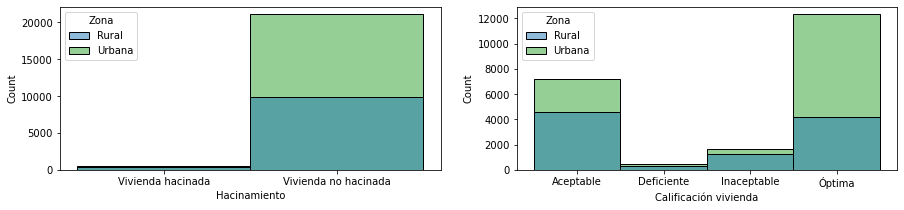

In [11]:
# Otras condiciones de la vivienda
fig, axes = plt.subplots(1, 2, figsize=(15,3))
sns.histplot(data=df[['Hacinamiento','Zona']], x='Hacinamiento',  hue='Zona', ax=axes[0],  palette=palette)
sns.histplot(data=df[['Calificación vivienda','Zona']], x='Calificación vivienda',  hue='Zona', ax=axes[1],  palette=palette)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

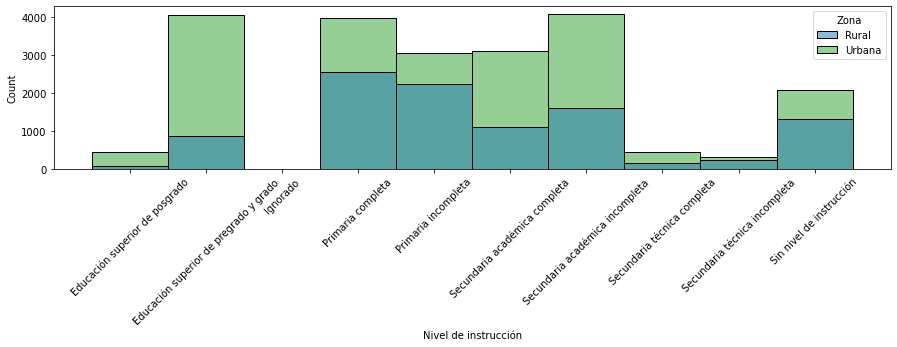

In [12]:
# Nivel de instrucción
plt.figure(figsize=(15,3))
sns.histplot(data=df[['Nivel de instrucción','Zona']], x='Nivel de instrucción',  hue='Zona',  palette=palette)
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

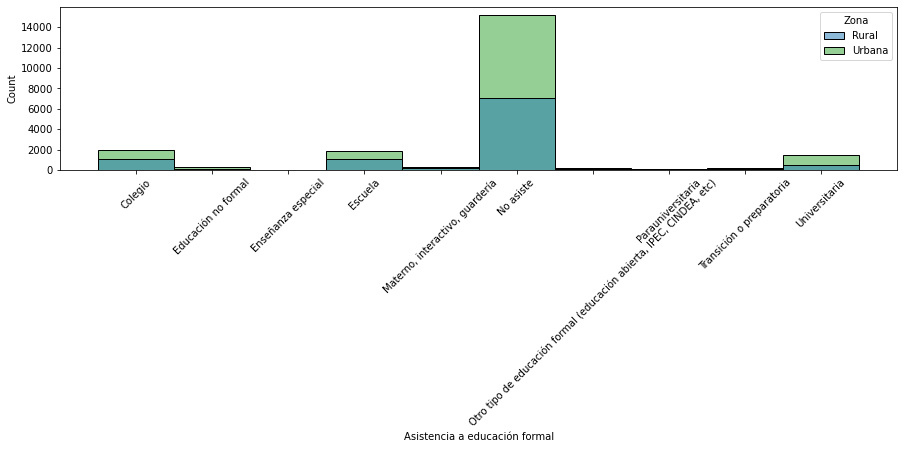

In [13]:
# Asistencia a educación formal
plt.figure(figsize=(15,3))
sns.histplot(data=df[['Asistencia a educación formal','Zona']], x='Asistencia a educación formal',  hue='Zona',  palette=palette)
plt.xticks(rotation=45)

<AxesSubplot:xlabel='E4 Bajo desarrollo', ylabel='Count'>

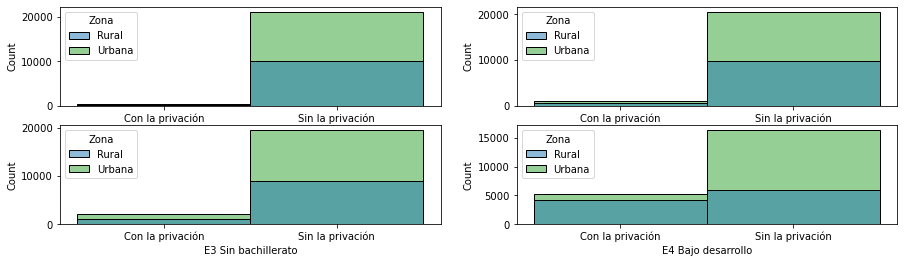

In [14]:
# Estado de paredes exterior, techos y pisos
fig, axes = plt.subplots(2, 2, figsize=(15,4))
sns.histplot(data=df[['E1 No educación formal','Zona']], x='E1 No educación formal',  hue='Zona', ax=axes[0,0],  palette=palette)
sns.histplot(data=df[['E2 Rezago educativo','Zona']], x='E2 Rezago educativo',  hue='Zona', ax=axes[0,1],  palette=palette)
sns.histplot(data=df[['E3 Sin bachillerato','Zona']], x='E3 Sin bachillerato',  hue='Zona', ax=axes[1,0],  palette=palette)
sns.histplot(data=df[['E4 Bajo desarrollo','Zona']], x='E4 Bajo desarrollo',  hue='Zona', ax=axes[1,1],  palette=palette)

<AxesSubplot:xlabel='T3 Independiente informal', ylabel='Count'>

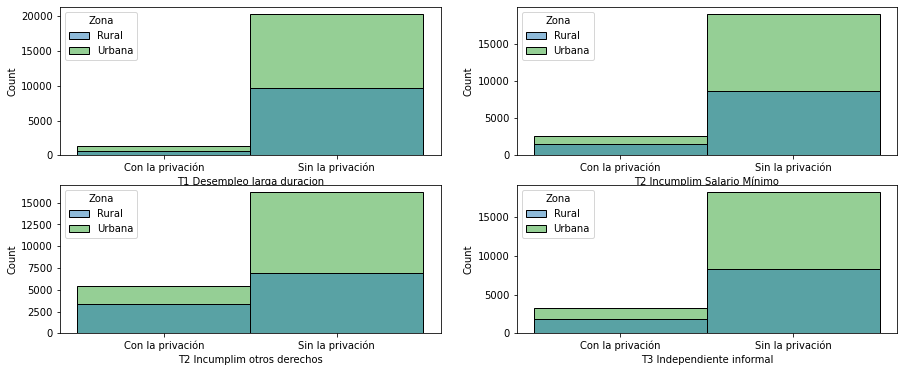

In [15]:
# Condiciones de empleo
fig, axes = plt.subplots(2, 2, figsize=(15,6))
sns.histplot(data=df[['T1 Desempleo larga duracion','Zona']], x='T1 Desempleo larga duracion',  hue='Zona', ax=axes[0,0],  palette=palette)
sns.histplot(data=df[['T2 Incumplim Salario Mínimo','Zona']], x='T2 Incumplim Salario Mínimo',  hue='Zona', ax=axes[0,1],  palette=palette)
sns.histplot(data=df[['T2 Incumplim otros derechos','Zona']], x='T2 Incumplim otros derechos',  hue='Zona', ax=axes[1,0],  palette=palette)
sns.histplot(data=df[['T3 Independiente informal','Zona']], x='T3 Independiente informal',  hue='Zona', ax=axes[1,1],  palette=palette)

<AxesSubplot:xlabel='PS4 No labora obligación familiar', ylabel='Count'>

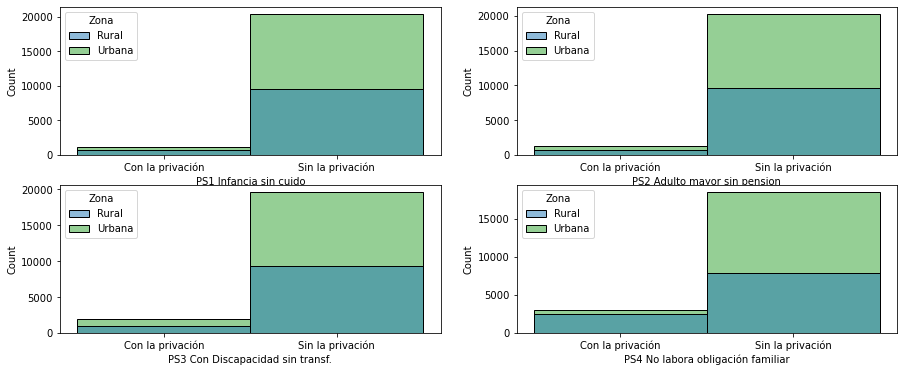

In [16]:
# Condiciones de familia
fig, axes = plt.subplots(2, 2, figsize=(15,6))
sns.histplot(data=df[['PS1 Infancia sin cuido','Zona']], x='PS1 Infancia sin cuido',  hue='Zona', ax=axes[0,0],  palette=palette)
sns.histplot(data=df[['PS2 Adulto mayor sin pension','Zona']], x='PS2 Adulto mayor sin pension',  hue='Zona', ax=axes[0,1],  palette=palette)
sns.histplot(data=df[['PS3 Con Discapacidad sin transf.','Zona']], x='PS3 Con Discapacidad sin transf.',  hue='Zona', ax=axes[1,0],  palette=palette)
sns.histplot(data=df[['PS4 No labora obligación familiar','Zona']], x='PS4 No labora obligación familiar',  hue='Zona', ax=axes[1,1],  palette=palette)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

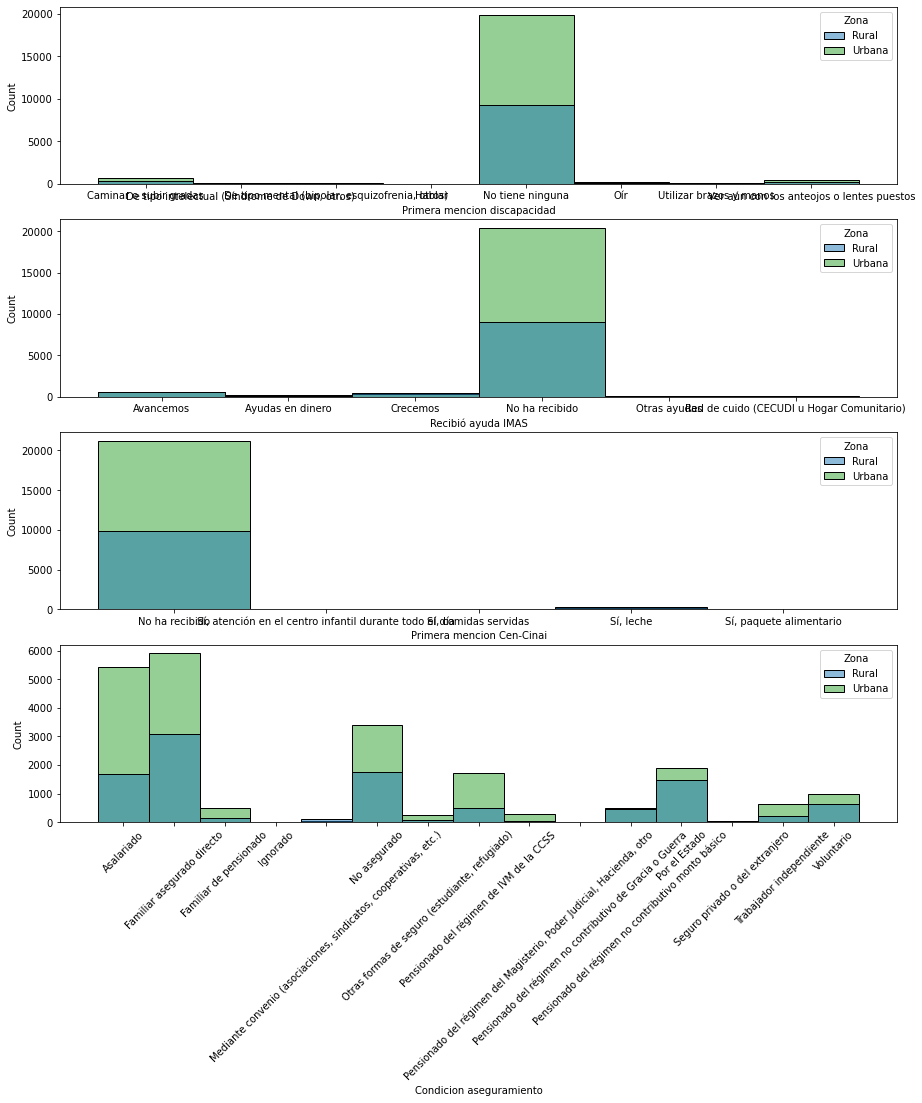

In [17]:
# Condiciones de subsidio y aseguramiento
fig, axes = plt.subplots(4, 1, figsize=(15,15))
sns.histplot(data=df[['Primera mencion discapacidad','Zona']], x='Primera mencion discapacidad',  hue='Zona', ax=axes[0],  palette=palette)
sns.histplot(data=df[['Recibió ayuda IMAS','Zona']], x='Recibió ayuda IMAS',  hue='Zona', ax=axes[1],  palette=palette)
sns.histplot(data=df[['Primera mencion Cen-Cinai','Zona']], x='Primera mencion Cen-Cinai',  hue='Zona', ax=axes[2],  palette=palette)
sns.histplot(data=df[['Condicion aseguramiento','Zona']], x='Condicion aseguramiento',  hue='Zona', ax=axes[3],  palette=palette)
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

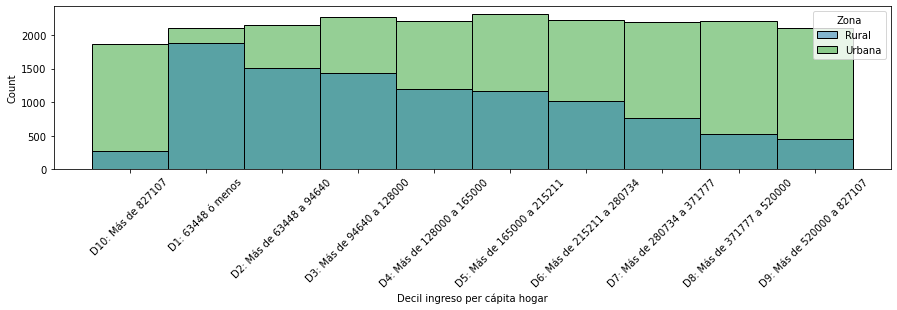

In [18]:
# Ingreso per cápita
plt.figure(figsize=(15,3))
sns.histplot(data=df[['Decil ingreso per cápita hogar','Zona']], x='Decil ingreso per cápita hogar',  hue='Zona',  palette=palette)
plt.xticks(rotation=45)

### Estadísticas descriptiva de variables numéricas

In [19]:
df.describe()

,Personas en vivienda,Ingreso neto hogar,Total Transf Monetaria Hogar,Transf no monetaria hogar,Edad,Canasta Básica Alimentaria
count,31827.000000,3.182700e+04,3.182700e+04,31827.000000,31827.000000,31827.000000
mean,3.930122,1.013707e+06,1.370281e+05,3245.306919,36.573255,48598.902724
std,1.781404,1.214323e+06,3.085827e+05,23469.748992,21.970103,3938.553688
min,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,42871.000000
25%,3.000000,3.640000e+05,0.000000e+00,0.000000,18.000000,42871.000000
50%,4.000000,6.567760e+05,3.000000e+04,0.000000,35.000000,51307.000000
75%,5.000000,1.242692e+06,1.500000e+05,0.000000,54.000000,51307.000000
max,17.000000,4.283500e+07,9.262800e+06,962000.000000,97.000000,51307.000000


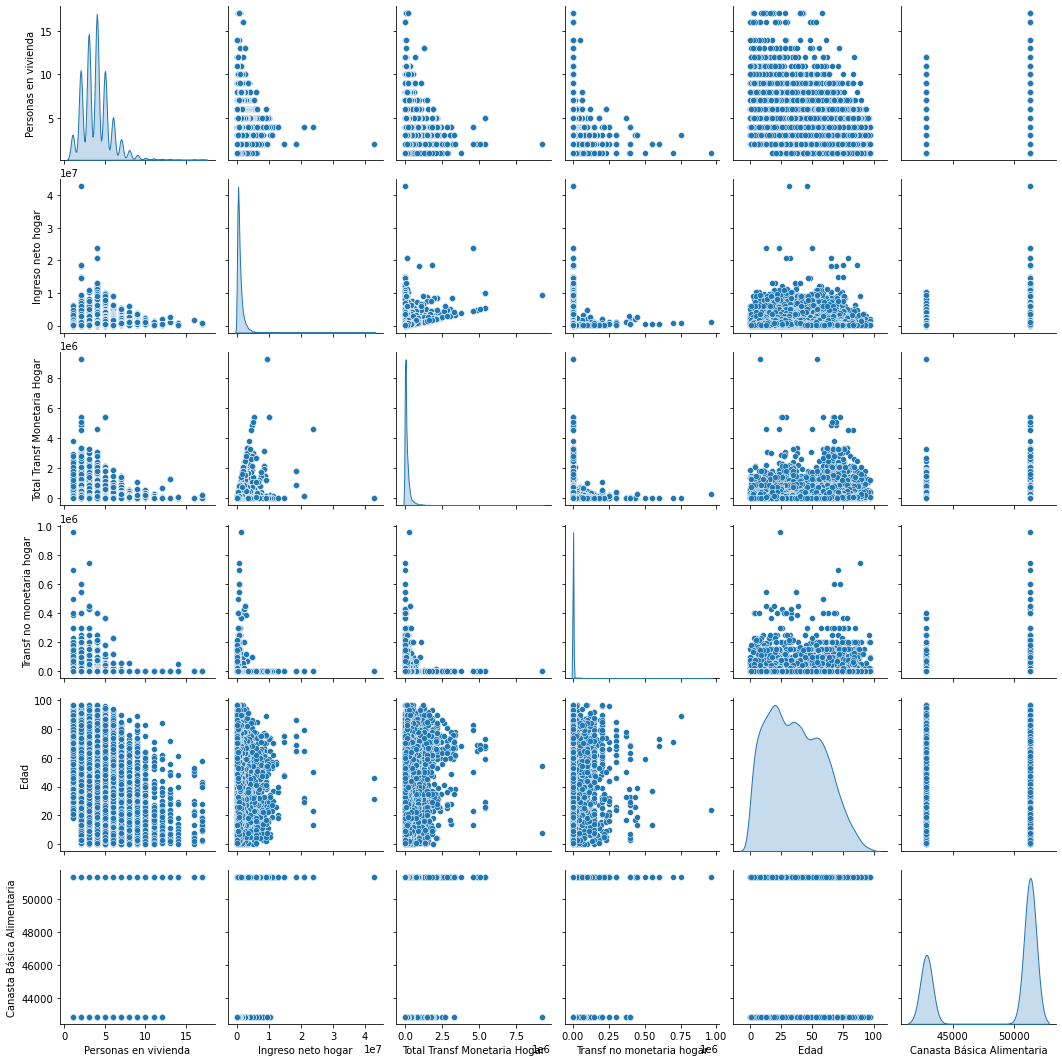

In [20]:
sns.pairplot(df[vars_numericas], diag_kind="kde")

## 4. Aplicar Label encoder y Ordinal encoder en variables categóricas, y estandarizar todos los datos

In [4]:
# Crear DataFrame para esta prueba
df_JP = df.copy()

# Variables para Ordinal Encoder
vars_categoricas_ord_enc = ['Est Paredes exterior', 'Est techo', 'Est piso', 'Mts2 vivienda', 'Calificación vivienda',
                            'Nivel de instrucción', 'Decil ingreso per cápita hogar']

vars_categoricas_lab_enc = [x for x in vars_categoricas if x not in vars_categoricas_ord_enc]


# Aplicación de Label encoder a columnas específicas
LE =LabelEncoder()
df_JP[vars_categoricas_lab_enc] = df_JP[vars_categoricas_lab_enc].apply(LabelEncoder().fit_transform)

# Diccionarios para Ordinal Encoder

Est_dict = { 'Malo':1, 'Regular':2, 'Bueno':3 }

Mts2_vivienda_dict = {'Menos de 30m²' : 1,
                      'De 30m² a 40m²': 2,
                      'De 41m² a 60m²' : 3,
                      'De 61m² a 100m²' : 4,
                      'De 101m² a 150m²' : 5,
                      'De 151m² a 200m²' : 6,
                      'Más de 200m²' : 7}

Calificación_vivienda_dict = {'Inaceptable' : 1,
                              'Deficiente' : 2,
                              'Aceptable' : 3,
                              'Óptima' : 4}

Nivel_de_instrucción_dict = {'Educación superior de posgrado' : 10,
                             'Educación superior de pregrado y grado' : 9,
                             'Secundaria académica completa' : 8,
                             'Secundaria técnica completa' : 7,
                             'Secundaria académica incompleta' : 6,
                             'Secundaria técnica incompleta' : 5,
                             'Primaria completa' : 4,
                             'Primaria incompleta' : 3,
                             'Sin nivel de instrucción' : 2,
                             'Ignorado' : 1}

Decil_ingreso_percapitahogar_dict = {'D10: Más de 827107' : 10,
                                     'D9: Más de 520000 a 827107' : 9,
                                     'D8: Más de 371777 a 520000' : 8,
                                     'D7: Más de 280734 a 371777' : 7,
                                     'D6: Más de 215211 a 280734' : 6,
                                     'D5: Más de 165000 a 215211' : 5,
                                     'D4: Más de 128000 a 165000' : 4,
                                     'D3: Más de 94640 a 128000' : 3,
                                     'D2: Más de 63448 a 94640' : 2,
                                     'D1: 63448 ó menos' : 1}

# Aplicación de Ordinal encoder a columnas específicas

df_JP['Est Paredes exterior'] = df_JP['Est Paredes exterior'].map(Est_dict)
df_JP['Est techo'] = df_JP['Est techo'].map(Est_dict)
df_JP['Est piso'] = df_JP['Est piso'].map(Est_dict)
df_JP['Mts2 vivienda'] = df_JP['Mts2 vivienda'].map(Mts2_vivienda_dict)
df_JP['Calificación vivienda'] = df_JP['Calificación vivienda'].map(Calificación_vivienda_dict)
df_JP['Nivel de instrucción'] = df_JP['Nivel de instrucción'].map(Nivel_de_instrucción_dict)
df_JP['Decil ingreso per cápita hogar'] = df_JP['Decil ingreso per cápita hogar'].map(Decil_ingreso_percapitahogar_dict)
cat_a_int = ['Est Paredes exterior', 'Est techo', 'Est piso', 'Mts2 vivienda', 'Calificación vivienda', 'Nivel de instrucción', 'Decil ingreso per cápita hogar']
df_JP[cat_a_int] = df_JP[cat_a_int].astype(int)

# Estandarizar todas las variables

df_JP_scale = scale(df_JP)
df_JP


,Zona,Est Paredes exterior,Est techo,Est piso,Mts2 vivienda,Abastecimiento agua,Fuente agua,Servicio sanitario,Exclusividad Serv sanitario,Sistema eliminación basura,...,Total Transf Monetaria Hogar,Transf no monetaria hogar,Sexo,Edad,Primera mencion discapacidad,Recibió ayuda IMAS,Primera mencion Cen-Cinai,Condicion aseguramiento,Asistencia a educación formal,Canasta Básica Alimentaria
0,1,3,2,2,4,1,0,0,1,0,...,140833.333333,0.0,1,49.0,4,3,0,14,5,51307.0
1,1,3,2,2,4,1,0,0,1,0,...,140833.333333,0.0,0,59.0,0,3,0,7,5,51307.0
2,1,3,2,2,4,1,0,0,1,0,...,140833.333333,0.0,1,27.0,4,3,0,0,5,51307.0
3,1,3,2,2,4,1,0,0,1,0,...,140833.333333,0.0,1,24.0,4,3,0,0,9,51307.0
4,1,1,3,1,2,1,0,0,1,0,...,175666.666667,0.0,1,37.0,4,3,0,0,5,51307.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31822,0,1,1,1,3,1,2,1,1,4,...,0.000000,0.0,0,9.0,4,3,0,5,3,42871.0
31823,0,3,3,3,2,1,2,1,1,4,...,88833.333333,0.0,1,74.0,0,3,0,10,5,42871.0
31824,0,3,3,3,2,1,2,1,1,4,...,88833.333333,0.0,1,13.0,4,3,0,11,0,42871.0
31825,0,1,1,1,1,1,2,3,1,4,...,0.000000,0.0,0,46.0,4,3,0,5,5,42871.0


### Cálculo del coeficiente de Silhouette y varianza intracluster

In [22]:
# Coeficiente de Silhouette
varianza_intra_cluster = []
silhouettes = []
for k in range (1, 40): # Evaluamos entre 1 a 10 clusters posibles
    kmeans = KMeans(n_clusters = k, random_state = 123).fit(df_JP_scale)
    varianza_intra_cluster.append(kmeans.inertia_)
    try:
        silhouette = silhouette_score(df_JP_scale, kmeans.labels_)
    except:
        silhouette = 0 # El índice de Silhouette sólo se puede calcular cuando se tiene K>1
    silhouettes.append(silhouette)

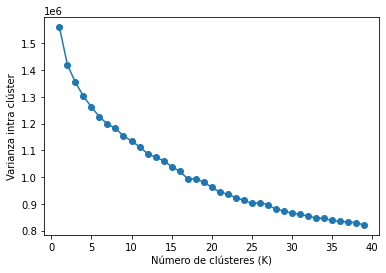

In [23]:
plt.plot(range(1, 40), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

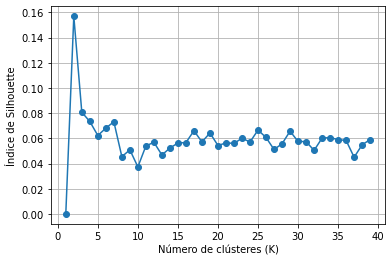

In [24]:
plt.plot(range(1, 40), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice de Silhouette')
plt.grid()
plt.show()

### 4.1 Clustering con Kmedias

In [25]:
kmeans_JP = KMeans(n_clusters = 2, random_state = 1234).fit_predict(df_JP_scale)
kmeans_JP = kmeans_JP.tolist()

In [26]:
zipped = list(zip(df_IPobreza, kmeans_JP))
resultados = pd.DataFrame(zipped, columns=['Indice_Pobreza', 'Kmeans'])
resultados['Kmeans'] = resultados['Kmeans'].apply(str)
resultados['Hogares'] = 1
pd.pivot_table(resultados[['Indice_Pobreza', 'Kmeans', 'Hogares']],
               values='Hogares', index=['Kmeans'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
Kmeans,,
0,20181,1064
1,4746,5836


In [27]:
#Accuracy
(20181+5836)/total_hogares

0.8174505922644296

### 4.2 Clustering con Kmedoides

In [28]:
Kmedoides = KMedoids(n_clusters = 2, metric = 'euclidean', random_state = 321).fit(df_JP_scale)
kmedoids_JP = list(Kmedoides.labels_)

In [29]:
Kmedoides = KMedoids(n_clusters = 2, metric = 'euclidean', random_state = 321).fit(df_JP_scale)
kmedoids_JP = list(Kmedoides.labels_)

resultados['Kmedoids'] = kmedoids_JP
resultados['Kmedoids'] = resultados['Kmedoids'].apply(str)
pd.pivot_table(resultados[['Indice_Pobreza', 'Kmedoids', 'Hogares']],
               values='Hogares', index=['Kmedoids'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
Kmedoids,,
0,10208,6262
1,14719,638


In [30]:
#Accuracy
(10208+638)/total_hogares

0.34077984101548997

### 4.3 Clustering Jerárquico Aglomerativo

In [31]:
CJA = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
CJA =CJA.fit_predict(df_JP_scale)
CJA_JP = list(CJA)

In [32]:
CJA = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
CJA =CJA.fit_predict(df_JP_scale)
CJA_JP = list(CJA)

resultados['CJA_simple'] = CJA_JP
resultados['CJA_simple'] = resultados['CJA_simple'].apply(str)
pd.pivot_table(resultados[['Indice_Pobreza', 'CJA_simple', 'Hogares']],
               values='Hogares', index=['CJA_simple'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
CJA_simple,,
0,24925.0,6900.0
1,2.0,NaN


In [33]:
CJA = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
CJA =CJA.fit_predict(df_JP_scale)
CJA_JP = list(CJA)

In [34]:
resultados['CJA_completo'] = CJA_JP
resultados['CJA_completo'] = resultados['CJA_completo'].apply(str)
pd.pivot_table(resultados[['Indice_Pobreza', 'CJA_completo', 'Hogares']],
               values='Hogares', index=['CJA_completo'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
CJA_completo,,
0,24920.0,6900.0
1,7.0,NaN


In [35]:
#Accuracy
(24920.0)/total_hogares

0.782983001853772

In [36]:
CJA = AgglomerativeClustering(n_clusters=2, affinity='manhattan', linkage='average')
CJA =CJA.fit_predict(df_JP_scale)
CJA_JP = list(CJA)

In [37]:
resultados['CJA_promedio'] = CJA_JP
resultados['CJA_promedio'] = resultados['CJA_promedio'].apply(str)
pd.pivot_table(resultados[['Indice_Pobreza', 'CJA_promedio', 'Hogares']],
               values='Hogares', index=['CJA_promedio'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
CJA_promedio,,
0,24927.0,6881.0
1,NaN,19.0


In [38]:
CJA = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
CJA =CJA.fit_predict(df_JP_scale)
CJA_JP = list(CJA)

In [39]:
CJA = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
CJA =CJA.fit_predict(df_JP_scale)
CJA_JP = list(CJA)

resultados['CJA_ward'] = CJA_JP
resultados['CJA_ward'] = resultados['CJA_ward'].apply(str)
pd.pivot_table(resultados[['Indice_Pobreza', 'CJA_ward', 'Hogares']],
               values='Hogares', index=['CJA_ward'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
CJA_ward,,
0,4403,4903
1,20524,1997


In [40]:
#Accuracy
(20524+4903)/total_hogares

0.7989128727181324

### 4.4 DBSCAN

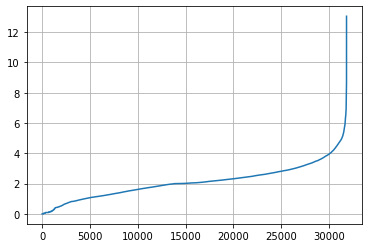

In [41]:
# Cálculo de la distancia a los n k-vecinos para determinar el valor de eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_JP_scale)
distances, indices = nbrs.kneighbors(df_JP_scale)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.grid()
plt.plot(distances)

In [42]:
# Identificación del codo de la gráfica
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
print('eps recomendado:', distances[knee.knee])

eps recomendado: 3.2917636160041335


In [43]:
# Agrupamiento con DBSCAN
db = DBSCAN(eps = 4, min_samples=10,metric='euclidean')
clusters=db.fit_predict(df_JP_scale)
resultados['DBSCAN'] = clusters
resultados['DBSCAN'] = resultados['DBSCAN'].apply(str)
df_DBSCAN = pd.pivot_table(resultados[['Indice_Pobreza', 'DBSCAN', 'Hogares']],
               values='Hogares', index=['DBSCAN'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)
df_DBSCAN

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
DBSCAN,,
-1,5086.0,5842.0
0,16823.0,449.0
1,609.0,35.0
10,13.0,2.0
11,148.0,8.0
12,15.0,9.0
13,178.0,1.0
14,NaN,12.0
15,12.0,2.0


In [44]:
#Accuracy
(16823+609+13+148+15+178+12+12+16+13+10+16+169+34+17+10+47+8+3+10+12+10+9+10+12+8+12+11+
10+10+11+669+9+2+12+12+581+290)/total_hogares

0.6237785528010809

## 5. Aplicar Label encoder y Ordinal encoder en variables categóricas, y estandarizar todos los datos. Luego, repetir análisis del numeral 4 aplicando PCA

### 5.1 Análisis de Componentes Principales PCA

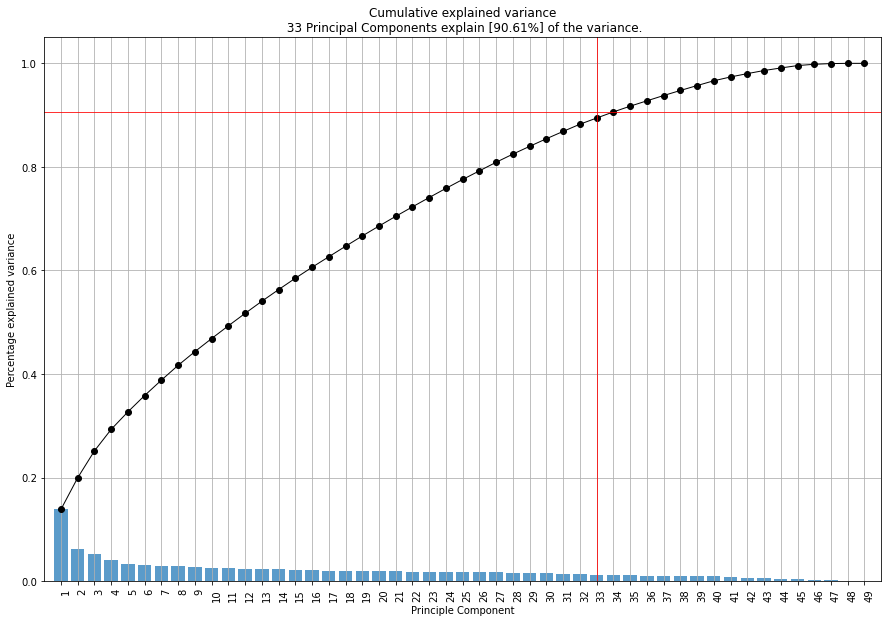

<Figure size 432x288 with 0 Axes>

In [45]:
# Análisis de Componentes Principales
model = pca(.89,normalize=True,verbose=True)
results = model.fit_transform(df_JP_scale)
fig, ax = model.plot()

In [46]:
results.get('explained_var')

array([0.13832347, 0.19943855, 0.25137885, 0.29294596, 0.3267965 ,
       0.35835463, 0.38803776, 0.41667647, 0.44311846, 0.46836675,
       0.4929824 , 0.51701051, 0.54043542, 0.56290888, 0.58486823,
       0.60602794, 0.6263927 , 0.64662668, 0.66651797, 0.68573909,
       0.70452549, 0.72281724, 0.74084165, 0.75852374, 0.77570834,
       0.79237738, 0.80894804, 0.82468369, 0.83968144, 0.85436331,
       0.86852298, 0.88238962, 0.89433073, 0.9061618 , 0.917209  ,
       0.92756717, 0.93780056, 0.94754232, 0.95704515, 0.96632045,
       0.97368112, 0.98012551, 0.98610781, 0.99103031, 0.99565584,
       0.99819003, 0.99949757, 1.        , 1.        ])

In [47]:
from sklearn.decomposition import PCA
n_components = 33
def df_pca(X, n_components):
    
    pca = PCA(n_components = n_components).fit(X)
    
    df_pca = pca.transform(X)
    
    balance_ratio=print(pca.explained_variance_ratio_)
    return df_pca, balance_ratio

In [48]:
def jerarquia(df,metric:str, method:str,scaleble:bool=False):   


    l=16
    inter=0.5
    dist_m = distance_matrix(df, df, p = 2)   
    dist = pdist(df, metric=metric)
    Z = linkage(df, method=method)
      


    pd.DataFrame(dist)
    fig, ax = plt.subplots(figsize=(50, 20))
    d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax)
    ax.set_xlabel('Observaciones', fontsize=14)
    ax.set_yticks(np.arange(0, l, inter))
    ax.set_ylabel('Distancia', fontsize=14)

    return df

In [49]:
dfpca= df_pca(df_JP_scale, 33)

[0.13832347 0.06111508 0.0519403  0.04156711 0.03385054 0.03155813
 0.02968312 0.02863871 0.02644198 0.02524828 0.02461565 0.0240281
 0.02342489 0.02247343 0.02195935 0.0211597  0.02036466 0.02023372
 0.01989126 0.0192211  0.01878619 0.01829169 0.01802417 0.01768184
 0.01718433 0.01666854 0.01656987 0.01573531 0.01499713 0.01468153
 0.01415955 0.01386661 0.01193042]


In [50]:
dfpca

(array([[-1.74078485, -1.30256219, -0.95481905, ...,  2.11563061,
         -0.12518775,  0.06231889],
        [-2.020501  , -1.34610899, -1.43895233, ...,  0.76292667,
         -0.08645843, -0.04233554],
        [-2.3145979 , -1.4880514 , -0.7330474 , ...,  0.0814636 ,
         -0.02013108,  0.04204083],
        ...,
        [ 1.60108574,  4.81153481, -0.26821574, ...,  2.26053385,
          0.38643927,  0.07925278],
        [ 8.4801572 ,  2.18747577, -4.16378097, ...,  0.12891501,
         -1.16914387, -0.70741713],
        [-0.06332442,  2.74491397, -1.68278695, ..., -0.07858087,
          0.44021794,  0.3408664 ]]),
 None)

In [52]:
# dist_m = distance_matrix(dfpca, dfpca)   
from pca import pca
from scipy.spatial import distance_matrix
dist=distance_matrix(df_JP_scale,df_JP_scale,p=2)
model = pca(4,normalize=True,verbose=True)
results = model.fit_transform(df_JP_scale)

#ver los pesos o loadings
loadings_pca=model.results['loadings'].transpose()
loadings_pca

,PC1,PC2,PC3,PC4
1,-0.157269,-0.390223,0.054280,-0.084573
2,-0.285977,0.225669,0.149789,-0.094637
3,-0.264898,0.222813,0.158719,-0.082606
4,-0.275450,0.198604,0.136450,-0.085598
5,-0.195664,-0.021050,-0.106297,0.177626
6,0.045202,0.029623,-0.030045,0.087456
7,0.109437,0.278101,-0.067090,0.188623
8,0.112848,0.157985,-0.007199,0.089886
9,-0.052294,-0.011384,0.003335,-0.048583
10,0.160826,0.323867,-0.088472,0.167302


### REPETIR EL ANALISIS DEL NUMERAL APLICANDO SVD 

In [6]:
U, S, Vt = np.linalg.svd(df_JP_scale, full_matrices=False)

print('U, S, V ='), U, S, Vt

U, S, V =


(None,
 array([[-3.74801452e-03, -4.21918378e-03,  3.35484884e-03, ...,
          3.26604008e-03,  6.22639985e-04,  9.50811811e-01],
        [-4.35026025e-03, -4.36023848e-03,  5.05589757e-03, ...,
          3.47288972e-03,  2.42273964e-04, -1.94754210e-01],
        [-4.98346859e-03, -4.82000966e-03,  2.57563238e-03, ...,
          3.24367025e-03,  2.87080730e-04,  2.66077470e-03],
        ...,
        [ 3.44723394e-03,  1.55852371e-02,  9.42400667e-04, ...,
         -2.72973444e-04, -1.57871105e-03,  1.17735748e-03],
        [ 1.82582890e-02,  7.08552721e-03,  1.46298434e-02, ...,
         -3.64985055e-04, -9.76238171e-04,  1.27236836e-03],
        [-1.36341338e-04,  8.89116162e-03,  5.91263324e-03, ...,
          2.78522626e-04,  2.52280823e-03,  1.50399853e-03]]),
 array([4.64455199e+02, 3.08723780e+02, 2.84608669e+02, 2.54607263e+02,
        2.29762262e+02, 2.21845978e+02, 2.15154642e+02, 2.11335582e+02,
        2.03068689e+02, 1.98432078e+02, 1.95930269e+02, 1.93577849e+02,
      

In [7]:
n=15
k=15
S2= np.resize(S,[n,1])*np.eye(n,k) #ponemos los valores singulares en una matriz diagonal

print(S2)

[[464.45519933   0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.         308.72378      0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.         284.60866894   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.         254.6072631    0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.         229.76226247
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
  2

In [8]:
#Reconstrucción
l=15
df_svd=pd.DataFrame(np.dot(U[:,0:l],np.dot(S2[0:l,0:l],Vt[0:l,:])))
df_svd.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,0.772057,0.051463,0.019628,0.082198,0.458123,0.089850,-0.637959,-0.592110,0.242736,-0.333644,...,0.938702,-0.046770,0.242460,0.612470,-0.175279,0.191439,0.112194,0.547418,0.400515,0.772057
1,0.701729,0.066680,0.039017,0.110599,0.708393,-0.017863,-0.638923,-0.635885,0.363719,-0.393457,...,0.938824,0.438031,0.061853,0.814243,-0.744957,0.148180,-0.143109,0.185760,0.176986,0.701729
2,0.902196,0.040700,0.023484,0.086443,0.344141,-0.069675,-0.458410,-0.531318,0.299847,-0.318186,...,0.030853,-0.004594,0.157928,-0.134914,0.213875,0.295126,-0.257323,-1.089104,0.271863,0.902196
3,0.843336,0.030300,0.025513,0.083549,0.338165,-0.121220,-0.416731,-0.551161,0.290277,-0.332948,...,0.015779,-0.040187,0.264025,0.118941,0.306465,1.093151,-0.065419,-1.031212,1.158052,0.843336
4,1.045193,-1.953655,-1.797564,-1.817479,-1.624838,0.108895,-0.752499,-0.427060,0.365734,-0.258824,...,-0.108135,0.180968,0.433176,0.338151,0.273168,0.239980,-0.726309,-0.777044,0.483950,1.045193


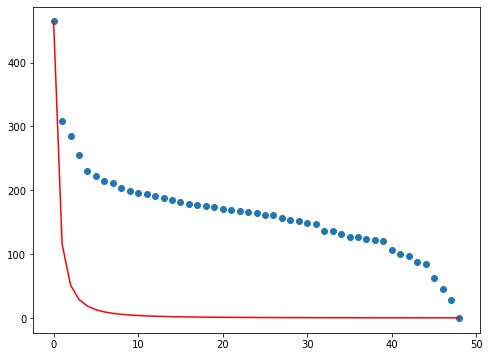

In [113]:
from scipy.linalg import svd #pueden explorar con sklearn
U,S,Vt = svd(df_JP_scale)
# observe cuan rapidamente caen los SVD
idx = range(len(S))
func = [S[0]/((i+1) ** 2) for i in idx ]

plt.figure(figsize = (8, 6))
plt.plot(idx, func, color = 'r')
plt.scatter(idx, S)

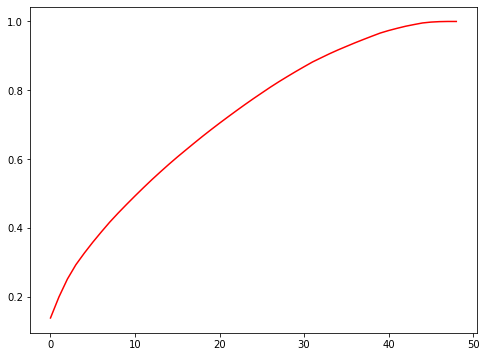

In [114]:
rg =49
idx = range(0,rg)
var_explained = np.round(S**2/np.sum(S**2), decimals=6)

cumsum=var_explained[0:rg].cumsum()

plt.figure(figsize = (8, 6))
plt.plot(idx,cumsum , color = 'r')

In [39]:
var_explained = np.round(S**2/np.sum(S**2), decimals=6)
sum(var_explained[0:15])

0.5848670000000001

In [115]:
sum(var_explained[0:34])

0.9061619999999999

In [116]:
sum(var_explained[0:34])

0.9061619999999999

In [9]:
kmeans_2 = KMeans(n_clusters = 2, random_state = 1234).fit_predict(df_svd)
kmeans_2 = kmeans_2.tolist()
zipped = list(zip(df_IPobreza, kmeans_2))
resultados = pd.DataFrame(zipped, columns=['Indice_Pobreza', 'Kmeans'])
resultados['Kmeans'] = resultados['Kmeans'].apply(str)
resultados['Hogares'] = 1
pd.pivot_table(resultados[['Indice_Pobreza', 'Kmeans', 'Hogares']],
               values='Hogares', index=['Kmeans'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
Kmeans,,
0,20376,1134
1,4551,5766


In [10]:
#Accuracy
(20376+5766)/total_hogares

0.8213780752191535

In [11]:
# Es coherente la clasificación del cluster y del IPM
df = pd.concat([df_svd, resultados], axis=1)
cluster_OK = df[(df["Kmeans"] == '0') & (df['Indice_Pobreza'] == 'No pobre multidimensional') |
               (df["Kmeans"] == '1') & (df['Indice_Pobreza'] == 'Pobre multidimensional')]
for i in list(cluster_OK.columns)[0:49]:
    print(cluster_OK[[ 'Indice_Pobreza', i, 'Hogares']].groupby(['Indice_Pobreza', i]).sum())

                                     Hogares
Indice_Pobreza            0                 
No pobre multidimensional -2.153928        1
                          -2.117164        1
                          -2.113771        1
                          -2.102668        1
                          -2.101735        1
...                                      ...
Pobre multidimensional     2.432372        1
                           2.451824        1
                           2.454746        1
                           2.508288        1
                           2.539321        1

[26089 rows x 1 columns]
                                     Hogares
Indice_Pobreza            1                 
No pobre multidimensional -1.850279        1
                          -1.849617        1
                          -1.833664        1
                          -1.832656        1
                          -1.213711        1
...                                      ...
Pobre multidimensional     0.

In [12]:
Kmedoides = KMedoids(n_clusters = 2, metric = 'euclidean', random_state = 321).fit(df_svd)
kmedoids_2 = list(Kmedoides.labels_)

resultados['Kmedoids'] = kmedoids_2
resultados['Kmedoids'] = resultados['Kmedoids'].apply(str)
pd.pivot_table(resultados[['Indice_Pobreza', 'Kmedoids', 'Hogares']],
               values='Hogares', index=['Kmedoids'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
Kmedoids,,
0,12962,171
1,11965,6729


In [13]:
#Accuracy
(12962+6729)/total_hogares

0.6186885348917586

In [14]:
CJA = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='single')
CJA =CJA.fit_predict(df_svd)
CJA_2 = list(CJA)

resultados['CJA_simple'] = CJA_2
resultados['CJA_simple'] = resultados['CJA_simple'].apply(str)
pd.pivot_table(resultados[['Indice_Pobreza', 'CJA_simple', 'Hogares']],
               values='Hogares', index=['CJA_simple'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
CJA_simple,,
0,24925.0,6900.0
1,2.0,NaN


In [15]:
CJA = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
CJA =CJA.fit_predict(df_svd)
CJA_2 = list(CJA)

resultados['CJA_ward'] = CJA_2
resultados['CJA_ward'] = resultados['CJA_ward'].apply(str)
pd.pivot_table(resultados[['Indice_Pobreza', 'CJA_ward', 'Hogares']],
               values='Hogares', index=['CJA_ward'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
CJA_ward,,
0,24233,4676
1,694,2224


In [16]:
#Accuracy
(24233+2224)/total_hogares

0.831275332265058

In [17]:
# Es coherente la clasificación del cluster y del IPM
df = pd.concat([df_svd, resultados], axis=1)
cluster_OK = df[(df["CJA_ward"] == '0') & (df['Indice_Pobreza'] == 'No pobre multidimensional') |
               (df["CJA_ward"] == '1') & (df['Indice_Pobreza'] == 'Pobre multidimensional')]
for i in list(cluster_OK.columns)[0:49]:
    print(cluster_OK[[ 'Indice_Pobreza', i, 'Hogares']].groupby(['Indice_Pobreza', i]).sum())

                                     Hogares
Indice_Pobreza            0                 
No pobre multidimensional -2.530259        1
                          -2.527192        1
                          -2.520831        1
                          -2.511480        1
                          -2.472198        1
...                                      ...
Pobre multidimensional     2.432372        1
                           2.451824        1
                           2.454746        1
                           2.508288        1
                           2.539321        1

[26396 rows x 1 columns]
                                     Hogares
Indice_Pobreza            1                 
No pobre multidimensional -2.524139        1
                          -2.522877        1
                          -2.518299        1
                          -2.509795        1
                          -2.492981        1
...                                      ...
Pobre multidimensional     0.

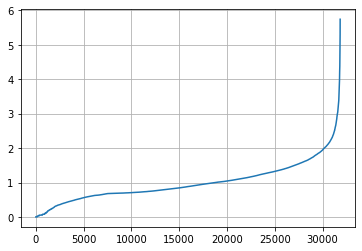

In [20]:
# Cálculo de la distancia a los n k-vecinos para determinar el valor de eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_svd)
distances, indices = nbrs.kneighbors(df_svd)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.grid()
plt.plot(distances)

In [21]:
# Identificación del codo de la gráfica
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
print('eps recomendado:', distances[knee.knee])

eps recomendado: 1.588126636022416


In [22]:
# Agrupamiento con DBSCAN
db = DBSCAN(eps = 1.58, min_samples=10,metric='euclidean')
clusters=db.fit_predict(df_svd)
resultados['DBSCAN'] = clusters
resultados['DBSCAN'] = resultados['DBSCAN'].apply(str)
df_DBSCAN = pd.pivot_table(resultados[['Indice_Pobreza', 'DBSCAN', 'Hogares']],
               values='Hogares', index=['DBSCAN'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)
df_DBSCAN

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
DBSCAN,,
-1,9339.0,6599.0
0,11455.0,138.0
1,344.0,NaN
10,NaN,16.0
11,NaN,12.0
12,2623.0,10.0
13,28.0,NaN
14,55.0,1.0
15,19.0,2.0


In [27]:
df_DBSCAN['No pobre multidimensional']=df_DBSCAN['No pobre multidimensional'].fillna(0)

In [34]:
#Accuracy
df_DBSCAN['No pobre multidimensional'].iloc[0:-1].sum()/total_hogares

0.7826688032173941

## 6. Estandarizar variables numéricas; aplicar Label encoder y Ordinal encoder en variables categóricas sin estandarizar

In [43]:
# Crear DataFrame para esta prueba
df_JP = df.copy()

# Aplicación de Label encoder a columnas específicas
LE =LabelEncoder()
df_JP[vars_categoricas_lab_enc] = df_JP[vars_categoricas_lab_enc].apply(LabelEncoder().fit_transform)

# Variables para Ordinal Encoder
vars_categoricas_ord_enc = ['Est Paredes exterior', 'Est techo', 'Est piso', 'Mts2 vivienda', 'Calificación vivienda',
                            'Nivel de instrucción', 'Decil ingreso per cápita hogar']

vars_categoricas_lab_enc = [x for x in vars_categoricas if x not in vars_categoricas_ord_enc]

# Diccionarios para Ordinal Encoder

Est_dict = { 'Malo':1, 'Regular':2, 'Bueno':3 }

Mts2_vivienda_dict = {'Menos de 30m²' : 1,
                      'De 30m² a 40m²': 2,
                      'De 41m² a 60m²' : 3,
                      'De 61m² a 100m²' : 4,
                      'De 101m² a 150m²' : 5,
                      'De 151m² a 200m²' : 6,
                      'Más de 200m²' : 7}

Calificación_vivienda_dict = {'Inaceptable' : 1,
                              'Deficiente' : 2,
                              'Aceptable' : 3,
                              'Óptima' : 4}

Nivel_de_instrucción_dict = {'Educación superior de posgrado' : 10,
                             'Educación superior de pregrado y grado' : 9,
                             'Secundaria académica completa' : 8,
                             'Secundaria técnica completa' : 7,
                             'Secundaria académica incompleta' : 6,
                             'Secundaria técnica incompleta' : 5,
                             'Primaria completa' : 4,
                             'Primaria incompleta' : 3,
                             'Sin nivel de instrucción' : 2,
                             'Ignorado' : 1}

Decil_ingreso_percapitahogar_dict = {'D10: Más de 827107' : 10,
                                     'D9: Más de 520000 a 827107' : 9,
                                     'D8: Más de 371777 a 520000' : 8,
                                     'D7: Más de 280734 a 371777' : 7,
                                     'D6: Más de 215211 a 280734' : 6,
                                     'D5: Más de 165000 a 215211' : 5,
                                     'D4: Más de 128000 a 165000' : 4,
                                     'D3: Más de 94640 a 128000' : 3,
                                     'D2: Más de 63448 a 94640' : 2,
                                     'D1: 63448 ó menos' : 1}

# Aplicación de Ordinal encoder a columnas específicas

df_JP['Est Paredes exterior'] = df_JP['Est Paredes exterior'].map(Est_dict)
df_JP['Est techo'] = df_JP['Est techo'].map(Est_dict)
df_JP['Est piso'] = df_JP['Est piso'].map(Est_dict)
df_JP['Mts2 vivienda'] = df_JP['Mts2 vivienda'].map(Mts2_vivienda_dict)
df_JP['Calificación vivienda'] = df_JP['Calificación vivienda'].map(Calificación_vivienda_dict)
df_JP['Nivel de instrucción'] = df_JP['Nivel de instrucción'].map(Nivel_de_instrucción_dict)
df_JP['Decil ingreso per cápita hogar'] = df_JP['Decil ingreso per cápita hogar'].map(Decil_ingreso_percapitahogar_dict)
cat_a_int = ['Est Paredes exterior', 'Est techo', 'Est piso', 'Mts2 vivienda', 'Calificación vivienda', 'Nivel de instrucción', 'Decil ingreso per cápita hogar']
df_JP[cat_a_int] = df_JP[cat_a_int].astype(int)

# Estandarizar solo las variables numéricas del dataset

num_features = df_JP[vars_numericas]
scaler = StandardScaler().fit(num_features.values)
num_features = scaler.transform(num_features.values)
 
df_JP[vars_numericas] = num_features

### 6.1 KMedias

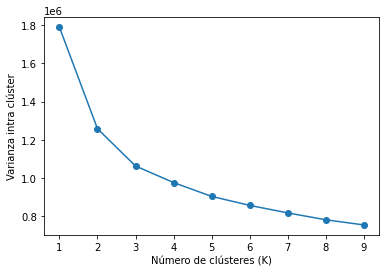

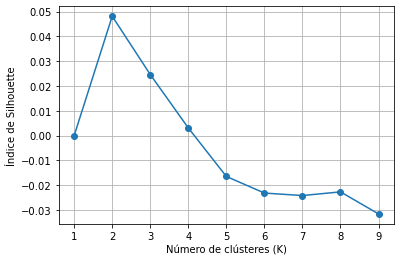

In [44]:
# Coeficiente de Silhouette
varianza_intra_cluster = []
silhouettes = []
for k in range (1, 10): # Evaluamos entre 1 a 10 clusters posibles
    kmeans = KMeans(n_clusters = k, random_state = 123).fit(df_JP)
    varianza_intra_cluster.append(kmeans.inertia_)
    try:
        silhouette = silhouette_score(df_JP_scale, kmeans.labels_)
    except:
        silhouette = 0 # El índice de Silhouette sólo se puede calcular cuando se tiene K>1
    silhouettes.append(silhouette)
        
plt.plot(range(1, 10), varianza_intra_cluster, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Varianza intra clúster')
plt.show()

plt.plot(range(1, 10), silhouettes, marker='o')
plt.xlabel('Número de clústeres (K)')
plt.ylabel('Índice de Silhouette')
plt.grid()
plt.show()

In [45]:
kmeans_2 = KMeans(n_clusters = 2, random_state = 1234).fit_predict(df_JP)
kmeans_2 = kmeans_2.tolist()

In [46]:
zipped = list(zip(df_IPobreza, kmeans_2))
resultados = pd.DataFrame(zipped, columns=['Indice_Pobreza', 'Kmeans_2'])
resultados['Kmeans_2'] = resultados['Kmeans_2'].apply(str)
resultados['Hogares'] = 1
pd.pivot_table(resultados[['Indice_Pobreza', 'Kmeans_2', 'Hogares']],
               values='Hogares', index=['Kmeans_2'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
Kmeans_2,,
0,17706,4584
1,7221,2316


In [47]:
#Accuracy
(17706+2316)/total_hogares

0.6290885097558676

### 6.2 Clustering Jerárquico Aglomerativo

In [48]:
CJA_2 = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
CJA_2 =CJA_2.fit_predict(df_JP)
CJA_2 = list(CJA_2)

In [49]:
resultados['CJA_ward'] = CJA_2
resultados['CJA_ward'] = resultados['CJA_ward'].apply(str)
pd.pivot_table(resultados[['Indice_Pobreza', 'CJA_ward', 'Hogares']],
               values='Hogares', index=['CJA_ward'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
CJA_ward,,
0,19906,4732
1,5021,2168


In [50]:
#Accuracy
(19906+2168)/total_hogares

0.6935620699406164

### 6.3 DBSCAN

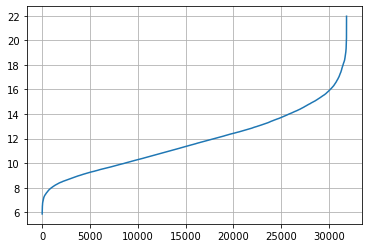

In [51]:
# Cálculo de la distancia a los n k-vecinos para determinar el valor de eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_JP_scale)
distances, indices = nbrs.kneighbors(df_JP)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.grid()
plt.plot(distances)

In [52]:
# Identificación del codo de la gráfica
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
print('eps recomendado:', distances[knee.knee])

eps recomendado: 14.60529953795874


In [53]:
# Agrupamiento con DBSCAN
db = DBSCAN(eps = 16, min_samples=5,metric='euclidean')
clusters=db.fit_predict(df_JP)
resultados['DBSCAN'] = clusters
resultados['DBSCAN'] = resultados['DBSCAN'].apply(str)
df_DBSCAN = pd.pivot_table(resultados[['Indice_Pobreza', 'DBSCAN', 'Hogares']],
               values='Hogares', index=['DBSCAN'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)
df_DBSCAN

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
DBSCAN,,
-1,3.0,NaN
0,24924.0,6900.0


In [54]:
#Accuracy
(24924)/total_hogares

0.7831086813083231

## 7. Estandarizar variables numéricas; aplicar Label encoder y Ordinal encoder en variables categóricas sin estandarizar. Luego, repetir análisis del numeral 6 aplicando PCA

### 7.1 Análisis de Componentes Principales PCA

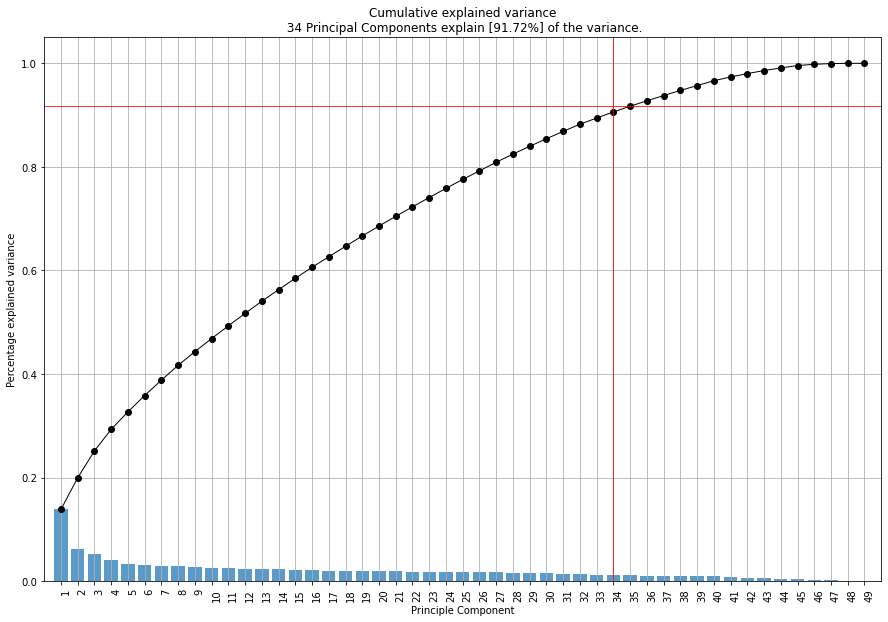

<Figure size 432x288 with 0 Axes>

In [55]:
# Análisis de Componentes Principales
model = pca(.90,normalize=True,verbose=True)
results = model.fit_transform(df_JP)
fig, ax = model.plot()

## 8. Estandarizar datos numéricos y mantener variables categóricas

In [56]:
# Crear DataFrame para esta prueba
df_JP_cat = df.copy()

# Aplicación de Label encoder a columnas específicas
LE =LabelEncoder()
df_JP_cat[vars_categoricas_lab_enc] = df_JP_cat[vars_categoricas_lab_enc].apply(LabelEncoder().fit_transform)

# Variables para Ordinal Encoder
vars_categoricas_ord_enc = ['Est Paredes exterior', 'Est techo', 'Est piso', 'Mts2 vivienda', 'Calificación vivienda',
                            'Nivel de instrucción', 'Decil ingreso per cápita hogar']

vars_categoricas_lab_enc = [x for x in vars_categoricas if x not in vars_categoricas_ord_enc]

# Diccionarios para Ordinal Encoder

Est_dict = { 'Malo':'1', 'Regular':'2', 'Bueno':'3' }

Mts2_vivienda_dict = {'Menos de 30m²' : '1',
                      'De 30m² a 40m²': '2',
                      'De 41m² a 60m²' : '3',
                      'De 61m² a 100m²' : '4',
                      'De 101m² a 150m²' : '5',
                      'De 151m² a 200m²' : '6',
                      'Más de 200m²' : '7'}

Calificación_vivienda_dict = {'Inaceptable' : '1',
                              'Deficiente' : '2',
                              'Aceptable' : '3',
                              'Óptima' : '4'}

Nivel_de_instrucción_dict = {'Educación superior de posgrado' : '10',
                             'Educación superior de pregrado y grado' : '9',
                             'Secundaria académica completa' : '8',
                             'Secundaria técnica completa' : '7',
                             'Secundaria académica incompleta' : '6',
                             'Secundaria técnica incompleta' : '5',
                             'Primaria completa' : '4',
                             'Primaria incompleta' : '3',
                             'Sin nivel de instrucción' : '2',
                             'Ignorado' : '1'}

Decil_ingreso_percapitahogar_dict = {'D10: Más de 827107' : '10',
                                     'D9: Más de 520000 a 827107' : '9',
                                     'D8: Más de 371777 a 520000' : '8',
                                     'D7: Más de 280734 a 371777' : '7',
                                     'D6: Más de 215211 a 280734' : '6',
                                     'D5: Más de 165000 a 215211' : '5',
                                     'D4: Más de 128000 a 165000' : '4',
                                     'D3: Más de 94640 a 128000' : '3',
                                     'D2: Más de 63448 a 94640' : '2',
                                     'D1: 63448 ó menos' : '1'}

# Aplicación de Ordinal encoder a columnas específicas

df_JP_cat['Est Paredes exterior'] = df_JP_cat['Est Paredes exterior'].map(Est_dict)
df_JP_cat['Est techo'] = df_JP_cat['Est techo'].map(Est_dict)
df_JP_cat['Est piso'] = df_JP_cat['Est piso'].map(Est_dict)
df_JP_cat['Mts2 vivienda'] = df_JP_cat['Mts2 vivienda'].map(Mts2_vivienda_dict)
df_JP_cat['Calificación vivienda'] = df_JP_cat['Calificación vivienda'].map(Calificación_vivienda_dict)
df_JP_cat['Nivel de instrucción'] = df_JP_cat['Nivel de instrucción'].map(Nivel_de_instrucción_dict)
df_JP_cat['Decil ingreso per cápita hogar'] = df_JP_cat['Decil ingreso per cápita hogar'].map(Decil_ingreso_percapitahogar_dict)

# Estandarizar solo las variables numéricas del dataset

num_features = df_JP_cat[vars_numericas]
scaler = StandardScaler().fit(num_features.values)
num_features = scaler.transform(num_features.values)
 
df_JP_cat[vars_numericas] = num_features
print(vars_numericas)

df_JP_cat.head(5)

Index(['Personas en vivienda', 'Ingreso neto hogar',
       'Total Transf Monetaria Hogar', 'Transf no monetaria hogar', 'Edad',
       'Canasta Básica Alimentaria'],
      dtype='object')


,Zona,Est Paredes exterior,Est techo,Est piso,Mts2 vivienda,Abastecimiento agua,Fuente agua,Servicio sanitario,Exclusividad Serv sanitario,Sistema eliminación basura,...,Total Transf Monetaria Hogar,Transf no monetaria hogar,Sexo,Edad,Primera mencion discapacidad,Recibió ayuda IMAS,Primera mencion Cen-Cinai,Condicion aseguramiento,Asistencia a educación formal,Canasta Básica Alimentaria
0,1,3,2,2,4,1,0,0,1,0,...,0.012332,-0.138278,1,0.565630,4,3,0,14,5,0.687598
1,1,3,2,2,4,1,0,0,1,0,...,0.012332,-0.138278,0,1.020801,0,3,0,7,5,0.687598
2,1,3,2,2,4,1,0,0,1,0,...,0.012332,-0.138278,1,-0.435747,4,3,0,0,5,0.687598
3,1,3,2,2,4,1,0,0,1,0,...,0.012332,-0.138278,1,-0.572298,4,3,0,0,9,0.687598
4,1,1,3,1,2,1,0,0,1,0,...,0.125215,-0.138278,1,0.019424,4,3,0,0,5,0.687598


### 8.1 Calcular distancia Gower y aplicar KMedoides

In [57]:
df_JP_gower = np.asarray(df_JP_cat)
gower_mat = gower.gower_matrix(df_JP_gower)

#### KMedoides con 2 clusters

In [ ]:
kMedoids = KMedoids(n_clusters=2, random_state = 0, metric = 'precomputed', method = 'pam', init =  'k-medoids++').fit(gower_mat) 
clusters = kMedoids.labels_
y_kmed_2 = kMedoids.fit_predict(gower_mat)

In [ ]:
Medoides_gower_2 = list(y_kmed_2)
resultados['Medoides_gower_2'] = Medoides_gower_2
resultados['Medoides_gower_2'] = resultados['Medoides_gower_2'].apply(str)
resultados[['Indice_Pobreza', 'Medoides_gower_2', 'Hogares']].groupby(['Indice_Pobreza', 'Medoides_gower_2']).sum()

Hogares
Indice_Pobreza            Medoides_gower_2         
No pobre multidimensional 0                   16267
                          1                    8660
Pobre multidimensional    0                    2275
                          1                    4625

In [ ]:
df_Medoides_2 = pd.pivot_table(resultados[['Indice_Pobreza', 'Medoides_gower_2', 'Hogares']],
               values='Hogares', index=['Medoides_gower_2'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)
df_Medoides_2

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
Medoides_gower_2,,
0,16267,2275
1,8660,4625


In [ ]:
#Accuracy
(16267+4625)/total_hogares

0.6564237911207466

#### KMedoides con 4 clusters

In [ ]:
kMedoids = KMedoids(n_clusters=4, random_state = 0, metric = 'precomputed', method = 'pam', init =  'k-medoids++').fit(gower_mat) 
clusters = kMedoids.labels_
y_kmed_4 = kMedoids.fit_predict(gower_mat)

In [ ]:
Medoides_gower_4 = list(y_kmed_4)
resultados['Medoides_gower_4'] = Medoides_gower
resultados['Medoides_gower_4'] = resultados['Medoides_gower_4'].apply(str)
resultados[['Indice_Pobreza', 'Medoides_gower_4', 'Hogares']].groupby(['Indice_Pobreza', 'Medoides_gower_4']).sum()

Hogares
Indice_Pobreza            Medoides_gower_4         
No pobre multidimensional 0                    4153
                          1                   15107
                          2                    4992
                          3                     675
Pobre multidimensional    0                    2082
                          1                     983
                          2                    1569
                          3                    2266

In [ ]:
df_Medoides_4 = pd.pivot_table(resultados[['Indice_Pobreza', 'Medoides_gower_4', 'Hogares']],
               values='Hogares', index=['Medoides_gower_4'],
               columns=['Indice_Pobreza'],
               aggfunc=np.sum)
df_Medoides_4

Indice_Pobreza,No pobre multidimensional,Pobre multidimensional
Medoides_gower_4,,
0,4153,2082
1,15107,983
2,4992,1569
3,675,2266


In [ ]:
#Accuracy
(4153+15107+4992+2266)/total_hogares

0.8331919439469633

## 9. Codificación de variables categóricas con Factorize 

In [ ]:
df_factorize = df.copy()
df_factorize[['Zona',
 'Est Paredes exterior',
 'Est techo',
 'Est piso',
 'Mts2 vivienda',
 'Abastecimiento agua',
 'Fuente agua',
 'Servicio sanitario',
 'Exclusividad  Serv sanitario',
 'Sistema eliminación basura',
 'Tiene computador portátil',
 'Tiene computador escritorio',
 'Tiene internet',
 'Calificación vivienda',
 'Hacinamiento',
 'Nivel de instrucción',
 'E1 No educación formal',
 'E2 Rezago educativo',
 'E3 Sin bachillerato',
 'E4 Bajo desarrollo',
 'VUI1 Mal Est techo piso',
 'VUI2 Mal Est paredes ext',
 'VUI3 Hacinamiento',
 'VUI3 Sin uso internet',
 'S1 Sin seguro salud',
 'S2 Sin servicio agua',
 'S3 Sin eliminación excretas',
 'S4 Sin eliminacion basura',
 'T1 Desempleo larga duracion',
 'T2 Incumplim Salario Mínimo',
 'T2 Incumplim otros derechos',
 'T3 Independiente informal',
 'PS1 Infancia sin cuido',
 'PS2 Adulto mayor sin pension',
 'PS3 Con Discapacidad sin transf.',
 'PS4 No labora obligación familiar',
 'Decil ingreso per cápita hogar',
 'Sexo',
 'Primera mencion discapacidad',
 'Recibió ayuda IMAS',
 'Primera mencion Cen-Cinai',
 'Condicion aseguramiento',
 'Asistencia a educación formal']]=df[['Zona',
 'Est Paredes exterior',
 'Est techo',
 'Est piso',
 'Mts2 vivienda',
 'Abastecimiento agua',
 'Fuente agua',
 'Servicio sanitario',
 'Exclusividad  Serv sanitario',
 'Sistema eliminación basura',
 'Tiene computador portátil',
 'Tiene computador escritorio',
 'Tiene internet',
 'Calificación vivienda',
 'Hacinamiento',
 'Nivel de instrucción',
 'E1 No educación formal',
 'E2 Rezago educativo',
 'E3 Sin bachillerato',
 'E4 Bajo desarrollo',
 'VUI1 Mal Est techo piso',
 'VUI2 Mal Est paredes ext',
 'VUI3 Hacinamiento',
 'VUI3 Sin uso internet',
 'S1 Sin seguro salud',
 'S2 Sin servicio agua',
 'S3 Sin eliminación excretas',
 'S4 Sin eliminacion basura',
 'T1 Desempleo larga duracion',
 'T2 Incumplim Salario Mínimo',
 'T2 Incumplim otros derechos',
 'T3 Independiente informal',
 'PS1 Infancia sin cuido',
 'PS2 Adulto mayor sin pension',
 'PS3 Con Discapacidad sin transf.',
 'PS4 No labora obligación familiar',
 'Decil ingreso per cápita hogar',
 'Sexo',
 'Primera mencion discapacidad',
 'Recibió ayuda IMAS',
 'Primera mencion Cen-Cinai',
 'Condicion aseguramiento',
 'Asistencia a educación formal']].apply(lambda x: pd.factorize(x)[0])

### Análisis de Componentes Principales PCA + Factorize

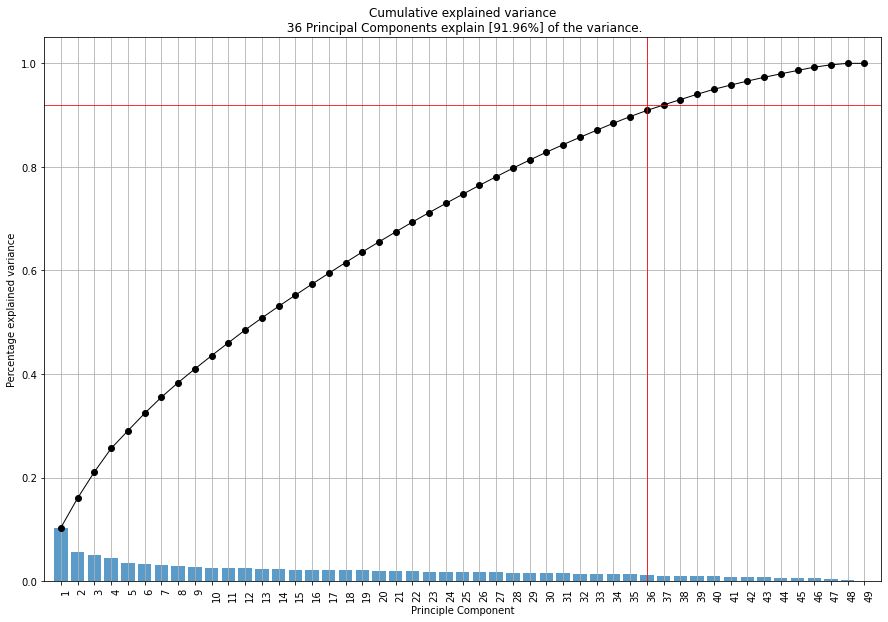

<Figure size 432x288 with 0 Axes>

In [ ]:
model = pca(.90,normalize=True,verbose=True)
results = model.fit_transform(df_factorize)
fig, ax = model.plot()